<a href="https://colab.research.google.com/github/hokknok/hack_CP_DigitalNinja_2021/blob/main/CP21_TrafficControl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive  
import requests
import json
import numpy as np
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.models import Sequential, Model #Два варианты моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики

%matplotlib inline

In [3]:
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [4]:
dt1_1=pd.read_excel('/content/drive/MyDrive/Hackathon_CP21_trafficControl/ДТ1_От_ул_Шумилова_к_ул_Фёдора_Полетаева.xls', skiprows=2)
dt1_2=pd.read_excel('/content/drive/MyDrive/Hackathon_CP21_trafficControl/ДТ1_От_ул_Шумилова_к_ул_Фёдора_Полетаева.xls', skiprows=2)
dt2_1=pd.read_excel('/content/drive/MyDrive/Hackathon_CP21_trafficControl/ДТ2_От_Жигулёвской_ул_к_ул_Зеленодольская.xls', skiprows=2)
dt2_2=pd.read_excel('/content/drive/MyDrive/Hackathon_CP21_trafficControl/ДТ2_От_ул_Зеленодольская_к_Жигулёвской_ул_.xls', skiprows=2)
dt3=pd.read_excel('/content/drive/MyDrive/Hackathon_CP21_trafficControl/ДТ3_От_пр_та_Волгоградский_к_ул_Шумилова.xls', skiprows=2)

In [5]:
dt1_1

,Время,Скорость,Интенсивность,Занятость,Загруженность,Полнота,Инт. Неопр.,Инт. Пеш.,Инт. Мото.,Инт. Легк.,Инт. Груз.
0,18.10.21 00:00:00,50.7,192,1.6,1.1,100,0,0,0,192,0
1,17.10.21 23:55:00,49.9,216,2.1,2.4,100,0,0,0,204,12
2,17.10.21 23:50:00,49.2,276,2.6,3.7,100,0,0,0,276,0
3,17.10.21 23:45:00,57.1,216,1.7,0.0,100,0,0,0,216,0
4,17.10.21 23:40:00,53.6,264,1.8,0.0,100,0,0,0,264,0
...,...,...,...,...,...,...,...,...,...,...,...
2011,11.10.21 00:20:00,47.6,312,2.9,5.6,100,0,0,0,312,0
2012,11.10.21 00:15:00,48.9,216,3.4,4.8,100,0,0,0,204,12
2013,11.10.21 00:10:00,53.0,216,2.1,0.0,100,0,0,0,204,12
2014,11.10.21 00:05:00,52.8,240,2.2,0.0,100,0,0,0,228,12


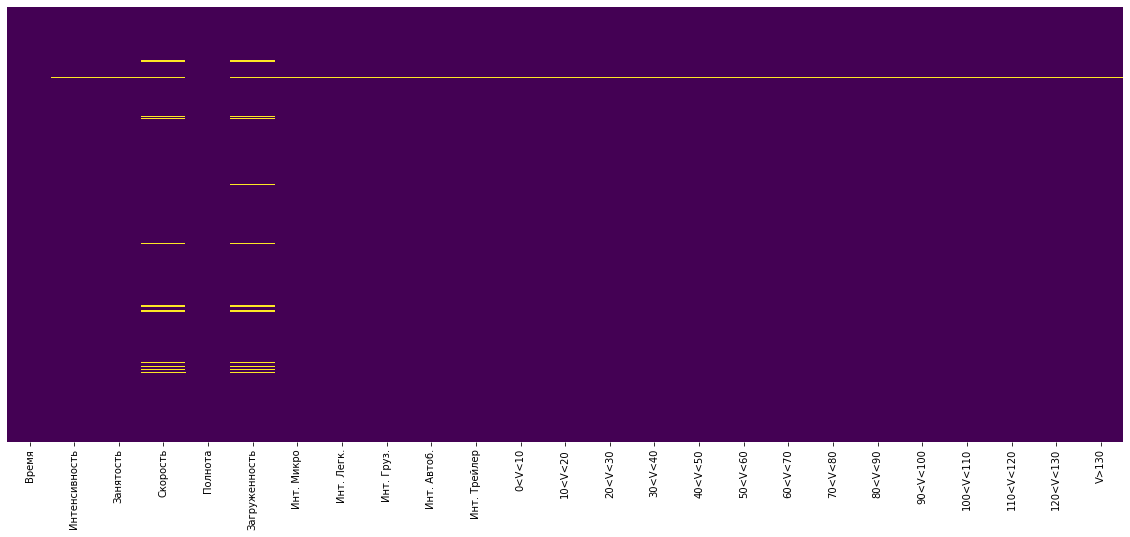

In [6]:
#пропуски
fig, ax = plt.subplots(figsize=(20,8)) 
sns_heatmap = sns.heatmap(dt2_1.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.show() 

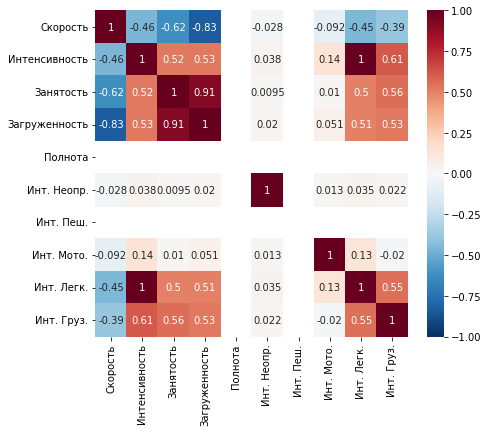

In [7]:
plt.figure(figsize=(7,6))
sns.heatmap(dt1_1.corr(), cmap=sns.color_palette("RdBu_r", 1000), vmin=-1, center=0, annot=True) 
plt.show()

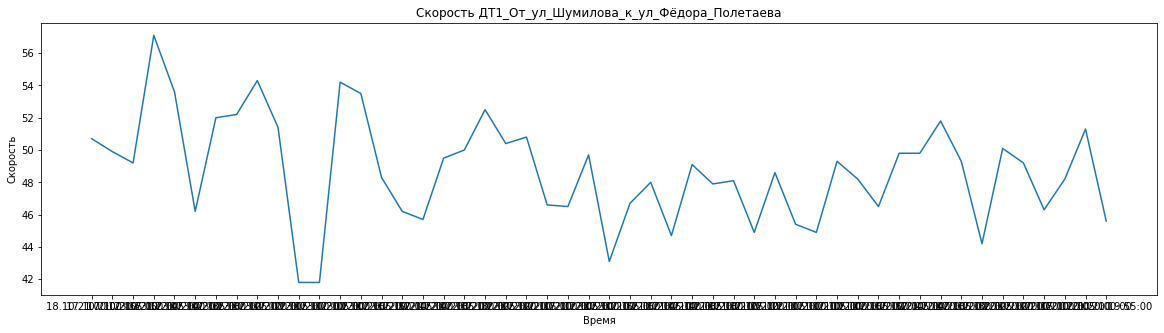

In [8]:
plt.figure(figsize=(20,5)) 
plt.plot(dt1_1.Время.values[:50], dt1_1.Скорость.values[:50]) 
plt.title('Скорость ДТ1_От_ул_Шумилова_к_ул_Фёдора_Полетаева') 
plt.xlabel('Время') 
plt.ylabel('Скорость') 
plt.show() 

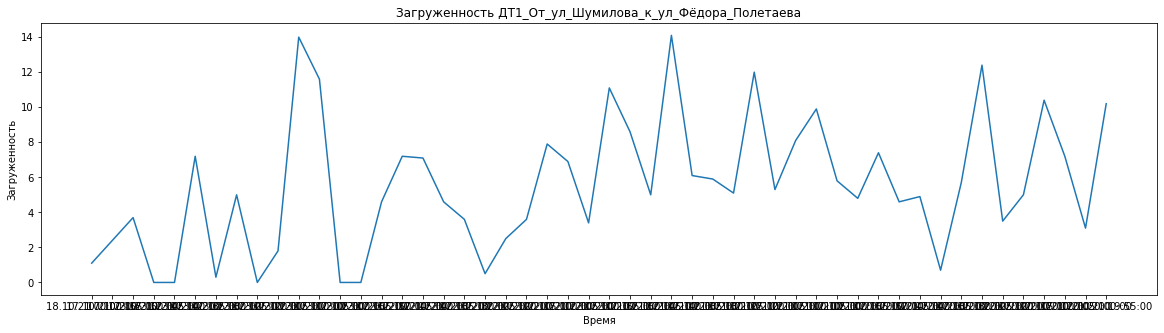

In [9]:
plt.figure(figsize=(20,5)) 
plt.plot(dt1_1.Время.values[:50], dt1_1.Загруженность.values[:50]) 
plt.title('Загруженность ДТ1_От_ул_Шумилова_к_ул_Фёдора_Полетаева') 
plt.xlabel('Время') 
plt.ylabel('Загруженность') 
plt.show()

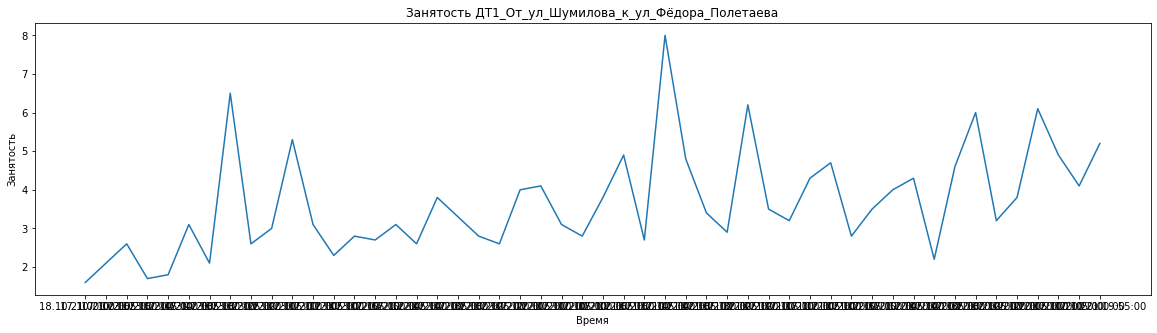

In [10]:
plt.figure(figsize=(20,5)) 
plt.plot(dt1_1.Время.values[:50], dt1_1.Занятость.values[:50]) 
plt.title('Занятость ДТ1_От_ул_Шумилова_к_ул_Фёдора_Полетаева') 
plt.xlabel('Время') 
plt.ylabel('Занятость')
plt.show() 

In [11]:
#ф-ция унификация набора признаков
def feat_uni(df, columns1=['Время', 'Скорость', 'Интенсивность', 'Занятость', 'Загруженность','Полнота','Инт. Легк.','Инт. Груз.']):
  return df.reindex(columns=columns1)

In [12]:
#унификация набора признаков
dt1_1=feat_uni(dt1_1)
dt1_2=feat_uni(dt1_2)
dt2_1=feat_uni(dt2_1)
dt2_2=feat_uni(dt2_2)
dt3  =feat_uni(dt3)
dt3

,Время,Скорость,Интенсивность,Занятость,Загруженность,Полнота,Инт. Легк.,Инт. Груз.
0,18.10.21 00:00:00,35.4,216,0.8,21.4,100,204,12
1,17.10.21 23:55:00,33.1,348,1.3,23.8,100,336,0
2,17.10.21 23:50:00,30.8,372,10.6,36.1,100,372,0
3,17.10.21 23:45:00,23.0,432,9.0,40.8,100,420,12
4,17.10.21 23:40:00,36.2,444,2.5,22.6,100,432,12
...,...,...,...,...,...,...,...,...
2012,11.10.21 00:20:00,32.6,216,3.5,26.7,100,204,12
2013,11.10.21 00:15:00,27.1,396,7.2,35.4,100,384,12
2014,11.10.21 00:10:00,35.5,372,4.7,25.6,100,372,0
2015,11.10.21 00:05:00,31.0,204,4.2,28.8,100,192,12


##Подготовка данных для передачи на front 

In [103]:
def feat_json(df,dfstr,columns1 = ['Time', 'Speed', 'Intensity', 'Staking', 'TrafficCongestion','Fullness','IntensityCar','IntensityTrck']):
  
  df=pd.DataFrame(df.to_numpy(),columns=columns1)

  df['Trend']=np.random.choice([True,False],size=df.shape[0])

  print(df.head())

  df.to_json('/content/' + dfstr + '.json')  

In [ ]:
feat_json(dt1_1,'dt1_1')
feat_json(dt1_2,'dt1_2')
feat_json(dt2_1,'dt2_1')
feat_json(dt2_2,'dt2_2')
feat_json(dt3,'dt3')

##Подготовка данных для обучения нейросетями

In [161]:
dt_concat = pd.concat([dt1_1, dt1_2,dt2_1, dt2_2,dt3])
dt_concat.shape

(10083, 8)

In [162]:
# dt_concat.index = pd.to_datetime(dt_concat.Время) # Превращаем колонку date в индекс
# dt_concat.drop('Время', axis=1, inplace=True) # Удаляем колонку date из датафрейма

In [163]:
dt_concat.head()

,Время,Скорость,Интенсивность,Занятость,Загруженность,Полнота,Инт. Легк.,Инт. Груз.
0,18.10.21 00:00:00,50.7,192.0,1.6,1.1,100,192.0,0.0
1,17.10.21 23:55:00,49.9,216.0,2.1,2.4,100,204.0,12.0
2,17.10.21 23:50:00,49.2,276.0,2.6,3.7,100,276.0,0.0
3,17.10.21 23:45:00,57.1,216.0,1.7,0.0,100,216.0,0.0
4,17.10.21 23:40:00,53.6,264.0,1.8,0.0,100,264.0,0.0


In [164]:
dt_concat.describe()

,Скорость,Интенсивность,Занятость,Загруженность,Полнота,Инт. Легк.,Инт. Груз.
count,9997.000000,10077.000000,10077.000000,9996.000000,10083.000000,10077.000000,10077.000000
mean,42.661538,418.924085,4.953865,17.077611,99.930576,321.802918,80.719262
std,7.934324,297.411104,5.133758,11.858504,2.538171,242.903748,131.637768
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37.300000,144.000000,1.500000,8.200000,100.000000,96.000000,0.000000
50%,43.600000,384.000000,4.400000,16.500000,100.000000,288.000000,24.000000
75%,47.700000,648.000000,6.800000,24.200000,100.000000,540.000000,84.000000
max,84.400000,1440.000000,94.800000,100.000000,100.000000,1176.000000,912.000000


In [165]:
for i in range(dt_concat.shape[0]):
  if dt_concat.iloc[i,4]==0.0:
   dt_concat.iloc[i,4]=0.01

In [166]:
dt_concat[:5]

,Время,Скорость,Интенсивность,Занятость,Загруженность,Полнота,Инт. Легк.,Инт. Груз.
0,18.10.21 00:00:00,50.7,192.0,1.6,1.10,100,192.0,0.0
1,17.10.21 23:55:00,49.9,216.0,2.1,2.40,100,204.0,12.0
2,17.10.21 23:50:00,49.2,276.0,2.6,3.70,100,276.0,0.0
3,17.10.21 23:45:00,57.1,216.0,1.7,0.01,100,216.0,0.0
4,17.10.21 23:40:00,53.6,264.0,1.8,0.01,100,264.0,0.0


##Нейросеть, предсказывающая Загруженность на временных рядах (5-минутках) 

In [167]:
step_in_the_last = 14   # По скольки шагам в прошлое определяем тренд     ##20,16,16,4
n_steps = 19            # Серию из скольки дней анализируем         ##44,42,48,6
forvard_lag = 1         # Предсказание какого бара в будущем делаем       ##1
# analyze_period = 30000    # Сколько баров в прошлое берем для тренировки модели (чтобы ихбежать тренировки на другой динамике рынка) #3000,2000,1000

In [168]:
# df_data = dt_concat.drop(dt_concat.columns[[1,2,3,5,6,7]], axis='columns') # Оставляем дату и цену, чтобы потом добавить в outputs
# del dt_concat['Время']

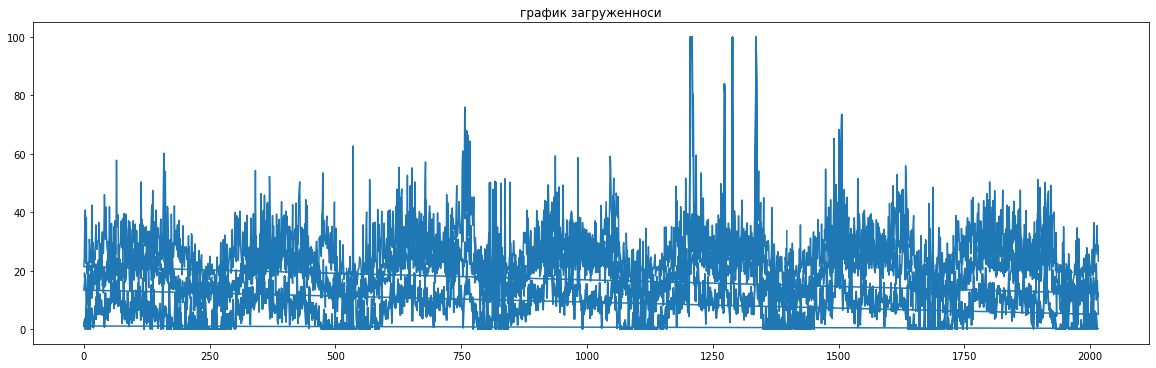

In [169]:
plt.figure(figsize=(20,8))
ax0 = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
dt_concat['Загруженность'].plot(ax = ax0)
plt.title('график загруженноси')
plt.show()

In [170]:
for i in range(1, step_in_the_last + 1):
  indicator_name = 'TrafCong_chng_%d' % (i)
  dt_concat[indicator_name] = dt_concat['Загруженность'].pct_change(i) # относительная доходность единицах

print(dt_concat.shape)
dt_concat[:5]

(10083, 22)


,Время,Скорость,Интенсивность,Занятость,Загруженность,Полнота,Инт. Легк.,Инт. Груз.,TrafCong_chng_1,TrafCong_chng_2,TrafCong_chng_3,TrafCong_chng_4,TrafCong_chng_5,TrafCong_chng_6,TrafCong_chng_7,TrafCong_chng_8,TrafCong_chng_9,TrafCong_chng_10,TrafCong_chng_11,TrafCong_chng_12,TrafCong_chng_13,TrafCong_chng_14
0,18.10.21 00:00:00,50.7,192.0,1.6,1.10,100,192.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17.10.21 23:55:00,49.9,216.0,2.1,2.40,100,204.0,12.0,1.181818,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,17.10.21 23:50:00,49.2,276.0,2.6,3.70,100,276.0,0.0,0.541667,2.363636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,17.10.21 23:45:00,57.1,216.0,1.7,0.01,100,216.0,0.0,-0.997297,-0.995833,-0.990909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,17.10.21 23:40:00,53.6,264.0,1.8,0.01,100,264.0,0.0,0.000000,-0.997297,-0.995833,-0.990909,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [171]:
dt_concat = dt_concat.dropna() 
print(dt_concat.shape)
dt_concat[:5]

(9982, 22)


,Время,Скорость,Интенсивность,Занятость,Загруженность,Полнота,Инт. Легк.,Инт. Груз.,TrafCong_chng_1,TrafCong_chng_2,TrafCong_chng_3,TrafCong_chng_4,TrafCong_chng_5,TrafCong_chng_6,TrafCong_chng_7,TrafCong_chng_8,TrafCong_chng_9,TrafCong_chng_10,TrafCong_chng_11,TrafCong_chng_12,TrafCong_chng_13,TrafCong_chng_14
14,17.10.21 22:50:00,48.3,288.0,2.7,4.6,100,276.0,12.0,459.000000,459.000000,-0.603448,-0.671429,1.555556,459.000000,-0.080000,14.333333,-0.361111,459.000000,459.000000,0.243243,0.916667,3.181818
15,17.10.21 22:45:00,46.2,336.0,3.1,7.2,100,324.0,12.0,0.565217,719.000000,719.000000,-0.379310,-0.485714,3.000000,719.000000,0.440000,23.000000,0.000000,719.000000,719.000000,0.945946,2.000000
16,17.10.21 22:40:00,45.7,264.0,2.6,7.1,100,252.0,12.0,-0.013889,0.543478,709.000000,709.000000,-0.387931,-0.492857,2.944444,709.000000,0.420000,22.666667,-0.013889,709.000000,709.000000,0.918919
17,17.10.21 22:35:00,49.5,372.0,3.8,4.6,100,360.0,12.0,-0.352113,-0.361111,0.000000,459.000000,459.000000,-0.603448,-0.671429,1.555556,459.000000,-0.080000,14.333333,-0.361111,459.000000,459.000000
18,17.10.21 22:30:00,50.0,372.0,3.3,3.6,100,372.0,0.0,-0.217391,-0.492958,-0.500000,-0.217391,359.000000,359.000000,-0.689655,-0.742857,1.000000,359.000000,-0.280000,11.000000,-0.500000,359.000000


In [172]:
for i in range(1, step_in_the_last + 1):
  indicator_name = 'TrafCong_chng_%d' % (i)
  indicator_name_new = 'TC_%d' % (i)
  dt_concat[indicator_name_new] = 0
  dt_concat.loc[dt_concat[indicator_name] > 0 , indicator_name_new] = 1

for i in range(1, step_in_the_last + 1):
  indicator_name = 'TrafCong_chng_%d' % (i)
  del dt_concat[indicator_name]

del dt_concat['Время'], dt_concat['Скорость'], dt_concat['Интенсивность'], dt_concat['Занятость'],dt_concat['Полнота'], dt_concat['Инт. Легк.'], dt_concat['Инт. Груз.']

print(dt_concat.shape)
dt_concat[:5]

(9982, 15)


,Загруженность,TC_1,TC_2,TC_3,TC_4,TC_5,TC_6,TC_7,TC_8,TC_9,TC_10,TC_11,TC_12,TC_13,TC_14
14,4.6,1,1,0,0,1,1,0,1,0,1,1,1,1,1
15,7.2,1,1,1,0,0,1,1,1,1,0,1,1,1,1
16,7.1,0,1,1,1,0,0,1,1,1,1,0,1,1,1
17,4.6,0,0,0,1,1,0,0,1,1,0,1,0,1,1
18,3.6,0,0,0,0,1,1,0,0,1,1,0,1,0,1


In [173]:
dt_concat

,Загруженность,TC_1,TC_2,TC_3,TC_4,TC_5,TC_6,TC_7,TC_8,TC_9,TC_10,TC_11,TC_12,TC_13,TC_14
14,4.6,1,1,0,0,1,1,0,1,0,1,1,1,1,1
15,7.2,1,1,1,0,0,1,1,1,1,0,1,1,1,1
16,7.1,0,1,1,1,0,0,1,1,1,1,0,1,1,1
17,4.6,0,0,0,1,1,0,0,1,1,0,1,0,1,1
18,3.6,0,0,0,0,1,1,0,0,1,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012,26.7,0,0,1,1,0,1,1,0,1,1,1,1,1,1
2013,35.4,1,1,1,1,1,0,1,1,1,1,1,1,1,1
2014,25.6,0,0,0,0,1,1,0,1,1,0,1,1,1,1
2015,28.8,1,0,1,0,1,1,1,0,1,1,1,1,1,1


In [174]:
indicator_name = 'TC_%d' % (step_in_the_last)
data_Y = dt_concat[indicator_name]
data_Y[:5]

14    1
15    1
16    1
17    1
18    1
Name: TC_14, dtype: int64

In [175]:
categorical_labels = to_categorical(data_Y, num_classes = 2)
print(len(categorical_labels))
categorical_labels[:5]

9982


array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [176]:
data = dt_concat.values
print(data.shape, type(data))

(9982, 15) <class 'numpy.ndarray'>


In [177]:
n_train = 300
xTrain = data[:-n_train-n_steps]
xTest = data[-n_train:]
yTrain = categorical_labels[:-n_train-n_steps]
yTest = categorical_labels[-n_train:]

print('xTrain: ', xTrain.shape, '\tyTrain:', yTrain.shape,
      '\nxTest:  ', xTest.shape, '\tyTest: ', yTest.shape)
xTrain.shape[0]+xTest.shape[0]

xTrain:  (9663, 15) 	yTrain: (9663, 2) 
xTest:   (300, 15) 	yTest:  (300, 2)


9963

In [178]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler # проверить все

xScaler = StandardScaler()
xScaler.fit(xTrain)
xTrain = xScaler.transform(xTrain)
xTest = xScaler.transform(xTest)

print(xTrain.shape, xTest.shape, type(xTrain))
xTest[-1:]

(9663, 15) (300, 15) <class 'numpy.ndarray'>


array([[ 0.55323137, -0.9719346 , -0.9468713 , -0.94628177, -0.94412297,
        -0.94588894, -0.9472645 , -0.95634865,  1.03571983, -0.96111953,
        -0.96151809,  1.031223  , -0.97032523,  1.02441044,  1.02250295]])

In [179]:
def split_sequence(sequence, Y, n_steps, forvard_lag):
  X, y = list(), list()
  for i in range(len(sequence)):
    end_ix = i + n_steps 
    if end_ix + (forvard_lag-1) > len(sequence)-1: 
      break 
    seq_x, seq_y = sequence[i:end_ix], Y[end_ix + (forvard_lag - 1)]
    X.append(seq_x)
    y.append(seq_y) 
  return np.array(X), np.array(y)

In [180]:
for i in [forvard_lag]:
  xTrain, yTrain = split_sequence(xTrain, yTrain, n_steps, forvard_lag=i)

  print('Массивы xTrain и yTrain:\t', xTrain.shape, yTrain.shape)

Массивы xTrain и yTrain:	 (9644, 19, 15) (9644, 2)


In [181]:
for i in [forvard_lag]:
  xTest, yTest = split_sequence(xTest, yTest, n_steps, forvard_lag=i)

  print('Массивы xTest и yTest:\t', xTest.shape, yTest.shape)

Массивы xTest и yTest:	 (281, 19, 15) (281, 2)


In [182]:
#Создаем нейросеть
  
drop = 0.4
input = Input(shape=(xTrain.shape[1], xTrain.shape[2]))
x = Flatten()(input)
x = RepeatVector(4)(x)
x = Conv1D(n_steps*2, 5, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = RepeatVector(4)(x)
x = Conv1D(n_steps, 5, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(n_steps*100, activation='relu')(x)
x = Dropout(drop)(x)
x = Dense(yTrain.shape[1], activation='sigmoid')(x)
model = Model(input, x)
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 19, 15)]          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 285)               0         
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 4, 285)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 4, 38)             54188     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 2, 38)             0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 76)                0         
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 4, 76)             0   

Epoch 1/20
302/302 [==============================] - 3s 8ms/step - loss: 0.7011 - accuracy: 0.4977 - val_loss: 0.7008 - val_accuracy: 0.4911
Epoch 2/20
302/302 [==============================] - 2s 7ms/step - loss: 0.6985 - accuracy: 0.5043 - val_loss: 0.6991 - val_accuracy: 0.4911
Epoch 3/20
302/302 [==============================] - 2s 7ms/step - loss: 0.6986 - accuracy: 0.5053 - val_loss: 0.6977 - val_accuracy: 0.4947
Epoch 4/20
302/302 [==============================] - 2s 7ms/step - loss: 0.6956 - accuracy: 0.5085 - val_loss: 0.6964 - val_accuracy: 0.4947
Epoch 5/20
302/302 [==============================] - 2s 7ms/step - loss: 0.6946 - accuracy: 0.5112 - val_loss: 0.6953 - val_accuracy: 0.4947
Epoch 6/20
302/302 [==============================] - 2s 7ms/step - loss: 0.6937 - accuracy: 0.5219 - val_loss: 0.6942 - val_accuracy: 0.5018
Epoch 7/20
302/302 [==============================] - 2s 7ms/step - loss: 0.6914 - accuracy: 0.5313 - val_loss: 0.6931 - val_accuracy: 0.5053
Epoch 

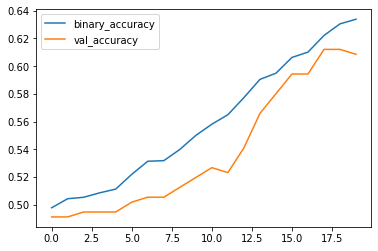

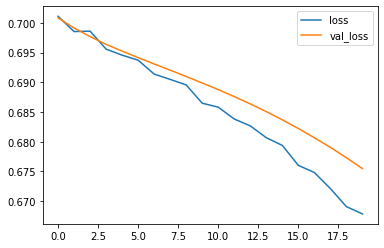

In [183]:
model.compile(optimizer=Adam(learning_rate = 5e-07),
              loss='binary_crossentropy',
              metrics=['accuracy']) 

# fit model
history = model.fit(xTrain, yTrain, epochs=20, verbose = 1,
                    validation_data=(xTest, yTest))

plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='binary_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [197]:
model.save_weights("weights.h5")

Epoch 1/20
302/302 [==============================] - 2s 7ms/step - loss: 0.6646 - accuracy: 0.6430 - val_loss: 0.6736 - val_accuracy: 0.6157
Epoch 2/20
302/302 [==============================] - 2s 7ms/step - loss: 0.6621 - accuracy: 0.6500 - val_loss: 0.6716 - val_accuracy: 0.6228
Epoch 3/20
302/302 [==============================] - 2s 7ms/step - loss: 0.6593 - accuracy: 0.6484 - val_loss: 0.6695 - val_accuracy: 0.6299
Epoch 4/20
302/302 [==============================] - 2s 7ms/step - loss: 0.6562 - accuracy: 0.6629 - val_loss: 0.6673 - val_accuracy: 0.6335
Epoch 5/20
302/302 [==============================] - 2s 7ms/step - loss: 0.6541 - accuracy: 0.6668 - val_loss: 0.6651 - val_accuracy: 0.6441
Epoch 6/20
302/302 [==============================] - 2s 7ms/step - loss: 0.6504 - accuracy: 0.6679 - val_loss: 0.6627 - val_accuracy: 0.6406
Epoch 7/20
302/302 [==============================] - 2s 7ms/step - loss: 0.6479 - accuracy: 0.6763 - val_loss: 0.6604 - val_accuracy: 0.6441
Epoch 

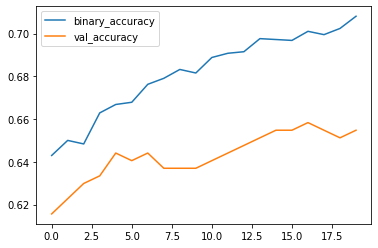

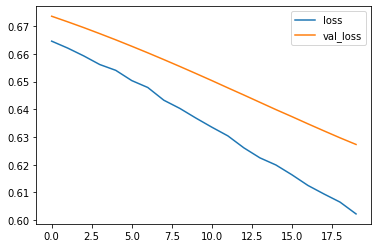

In [198]:
history = model.fit(xTrain, yTrain, epochs=20, verbose = 1,
                    validation_data=(xTest, yTest))

plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='binary_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

Epoch 1/40
302/302 [==============================] - 2s 7ms/step - loss: 0.5998 - accuracy: 0.7074 - val_loss: 0.6249 - val_accuracy: 0.6548
Epoch 2/40
302/302 [==============================] - 2s 7ms/step - loss: 0.5973 - accuracy: 0.7076 - val_loss: 0.6226 - val_accuracy: 0.6619
Epoch 3/40
302/302 [==============================] - 2s 7ms/step - loss: 0.5941 - accuracy: 0.7103 - val_loss: 0.6203 - val_accuracy: 0.6619
Epoch 4/40
302/302 [==============================] - 2s 7ms/step - loss: 0.5898 - accuracy: 0.7101 - val_loss: 0.6181 - val_accuracy: 0.6619
Epoch 5/40
302/302 [==============================] - 2s 7ms/step - loss: 0.5895 - accuracy: 0.7100 - val_loss: 0.6160 - val_accuracy: 0.6655
Epoch 6/40
302/302 [==============================] - 2s 7ms/step - loss: 0.5857 - accuracy: 0.7117 - val_loss: 0.6139 - val_accuracy: 0.6655
Epoch 7/40
302/302 [==============================] - 2s 7ms/step - loss: 0.5844 - accuracy: 0.7098 - val_loss: 0.6119 - val_accuracy: 0.6655
Epoch 

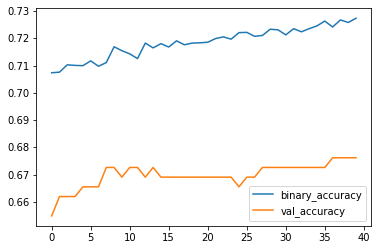

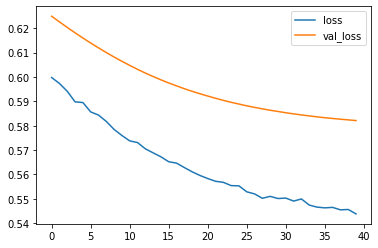

In [200]:
history = model.fit(xTrain, yTrain, epochs=40, verbose = 1,
                    validation_data=(xTest, yTest))

plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='binary_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [201]:
model.save_weights("weights3.h5")

## Нейросеть для определения класса аномалии

In [186]:
# dt_concat.groupby(['DTP']).count()

In [185]:
# dt_concat['DTP']=0
# dt_concat.DTP[dt_concat.Интенсивность>900]=1

In [187]:
# from tensorflow.keras.models import Sequential 
# from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization 
# from sklearn.model_selection import train_test_split
# from tensorflow.keras.optimizers import Adam, Adadelta 

In [188]:
# dataset = (dt_concat.drop(dt_concat, axis=1)).values             
# X = dataset[:,0:6].astype(float)   
# Y = dataset[:,6]       
# print(X.shape)                 
# print(Y.shape)                          

In [189]:
# x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=True)    
# print (x_train.shape)
# print (x_test.shape)
# print (y_train.shape)
# print (y_test.shape)

In [190]:
# def createModel():

#   model = Sequential()

#   model.add(Dense(60, input_dim=60, activation='relu'))
#   model.add(Dense(30,  activation='relu'))
#   model.add(Dense(1, activation='sigmoid'))

#   model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

#   return model

In [191]:
# model = createModel()
# model.summary()

In [192]:
# history=model.fit(x_train, 
#           y_train,
#           batch_size=8, 
#           epochs=100,
#           validation_split=0.2, 
#           verbose=1)

In [193]:
# def get_data(dt):
#   if dt==1:
#     return dt1_1
#   elif dt==2:
#     return dt1_2
#   elif dt==3:
#     return dt2_1
#   elif dt==4:
#     return dt2_2
#   elif dt==5:
#     return dt3

In [194]:
# !pip install flask-cors
# from flask import Flask, request, jsonify
# from flask_cors import CORS

In [207]:
app = Flask(__name__)
cors = CORS(app)

@app.route("/api/v2/")
def api_v2():
      # return json.dumps('FUCK YEEAHHH', cls=NpEncoder, ensure_ascii=False)
      return {"Error": "Not_in_Moscow"}

if __name__ == '__main__':
  app.run(host='0.0.0.0', port=5001)    

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://0.0.0.0:5001/ (Press CTRL+C to quit)


In [205]:
url = "http://192.168.0.106:5001/api/v2/"

response = requests.request("GET", url)

print(pprint.pprint(response.text))

KeyboardInterrupt: ignored